<p align="center">
<img src='../../img/VerticaMLPython.png' width="180px">
</p>

# Vertica ML Python Exercise 0

During this exercice, we will see:
<ul>
    <li> how to create a connection
    <li> load a dataset in the Vertica Database
    <li> draw an histogram
    <li> draw some time series (cumulative sums for example)
</ul>
## Initialization

If you have a DSN ready. The connection can be done easily with the vertica_cursor function of the VERTICA ML PYTHON library. This one will try to create a connection with pyodbc first and then vertica_python. If one of the two libraries is installed and you successfully settled your DSN, everything should work fine.

In [1]:
from vertica_ml_python.utilities import vertica_cursor
cur = vertica_cursor("VerticaDSN")

Otherwise, you can try to manually create the connection. With vertica_python:

In [2]:
#
# vertica_python
#
import vertica_python

'''
# Connection using all the DSN information
conn_info = {'host': "10.211.55.14", 'port': 5433, 'user': "dbadmin", 'password': "XxX", 'database': "testdb"}
cur = vertica_python.connect(** conn_info).cursor()
'''

# Connection using directly the DSN
from vertica_ml_python.utilities import to_vertica_python_format # This function will parse the odbc.ini file
dsn = "VerticaDSN"
cur = vertica_python.connect(** to_vertica_python_format(dsn), autocommit = True).cursor()

With pyodbc (recommended):

In [3]:
#
# pyodbc
#
import pyodbc

'''
# Connection using all the DSN information
driver = "/Library/Vertica/ODBC/lib/libverticaodbc.dylib"
server = "10.211.55.14"
database = "testdb"
port = "5433"
uid = "dbadmin"
pwd = "XxX"
dsn = ("DRIVER={}; SERVER={}; DATABASE={}; PORT={}; UID={}; PWD={};").format(driver, server, database, port, uid, pwd)
cur = pyodbc.connect(dsn).cursor()
'''

# Connection using directly the DSN
dsn = ("DSN=VerticaDSN")
cur = pyodbc.connect(dsn, autocommit = True).cursor()

With jaydebeapi:

In [4]:
#
# jaydebeapi
#
'''
import jaydebeapi

uid = "dbadmin"
pwd = "XxX"
driver = "/Library/Vertica/JDBC/vertica-jdbc-9.0.1-0.jar" #Path to JDBC Driver
url = 'jdbc:vertica://10.211.55.14:5433/'
name = 'com.vertica.jdbc.Driver'
cur = jaydebeapi.connect(name, [url, uid, pwd], driver).cursor()
'''

'\nimport jaydebeapi\n\nuid = "dbadmin"\npwd = "XxX"\ndriver = "/Library/Vertica/JDBC/vertica-jdbc-9.0.1-0.jar" #Path to JDBC Driver\nurl = \'jdbc:vertica://10.211.55.14:5433/\'\nname = \'com.vertica.jdbc.Driver\'\ncur = jaydebeapi.connect(name, [url, uid, pwd], driver).cursor()\n'

<br>
&#9888; Some functions may never ends because of the "autocommit" set to False attribute. If it is the case, please create manually a cursor with this attribute set to True. I really recommend the pyodbc cursor which is more robust than the other cursors.<br>

Let's now try to import some data.

Forest fires are a serious problem for the preservation of the Tropical Forests. Understanding the frequency of forest fires in a time series can help to take action to prevent them. Brazil has the largest rainforest on the planet that is the Amazon rainforest.

The file amazon.csv represents the number of forest fires in Brazil. These time series include the period of approximately 10 years (1998 to 2017). The data were obtained from the official website of the Brazilian government. We will try to explore the data and understand when forest fires are happening. 

The function read csv can help us to parse easily a CSV file. It is using flex tables to detect the data type. As parsing the different types can be time expensive, it is possible to use the parameter 'parse_n_lines' to limit the number of lines to parse in order to guess the different types. If you already know the columns names and types, the parameters 'header_names' and 'dtype' can be used to make the loading faster.

In [5]:
from vertica_ml_python.utilities import read_csv
from vertica_ml_python.utilities import drop_table
drop_table("amazon", cur)
amazon = read_csv("amazon.csv", cur)

The table amazon was successfully dropped.
The table public.amazon has been successfully created.


Many training datasets are available in vertica_ml_python.lear.datasets including the amazon one. A way to import the data can be to call the function.

In [6]:
from vertica_ml_python.learn.datasets import load_amazon
amazon = load_amazon(cur)

## Data Exploration of the Dataset

Let's explore the data by displaying descriptive statistics of all the columns.

In [7]:
amazon.describe(method = "categorical")

,dtype,unique,count,top,top_percent
"""year""",int,20,6454,1998,5.02
"""number""",int,1475,6454,0,9.56
"""date""",date,20,6454,2007-01-01,5.02
"""month""",varchar(20),12,6454,January,8.382
"""state""",varchar(32),23,6454,Rio,11.109


<object>

We can then look at the number of forest fire per month. Sometimes the graphic will not appear because of a Jupyter issue. You'll have to rerun the cell or write '%matplotlib inline' before the method. You don't have to write this command each time (once is enough to make it work). 

Besides, as most of the methods will return the Virtual Dataframe itself; You can be bored to always display the output. That's why you can affect a variable with the result of the transformation to avoid redundant outputs.

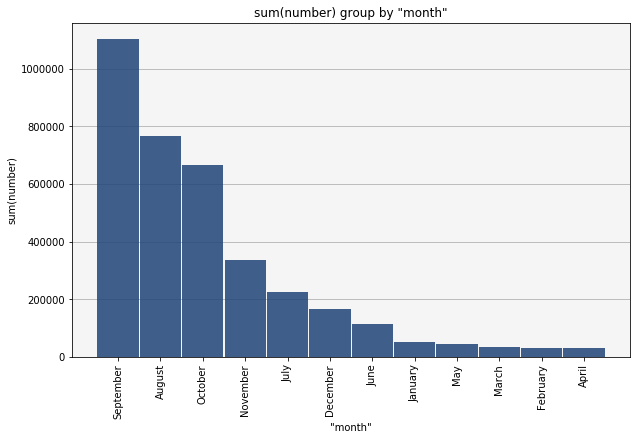

In [8]:
%matplotlib inline
x = amazon["month"].hist(method = "sum", of = "number", max_cardinality = 12)

<b>Question 1: </b>Compute the histogram of the number of forest fires per year and the one per state. What do you notice ?

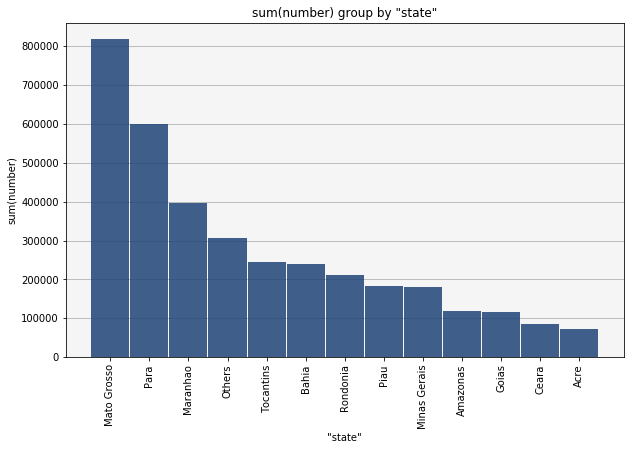

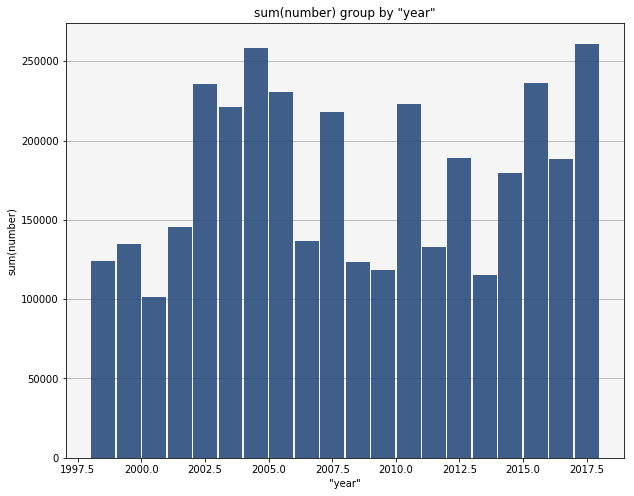

In [9]:
x = amazon["state"].hist(method = "sum", of = "number", max_cardinality = 12)
x = amazon["year"].hist(method = "sum", of = "number", max_cardinality = 12, h = 1)

<p style="color:red">We can notice that some states are very subject to forest fires. We can also notice a very high number of forest fires on some specific years.</p>

<b>Question 2: </b>Compute the cumulative sum of the number of forest fires in Brazil since the start of the dataset. Plot the time series using the 'plot' method. What do you notice?

The new vColumn "cum_sum" was added to the vDataframe.


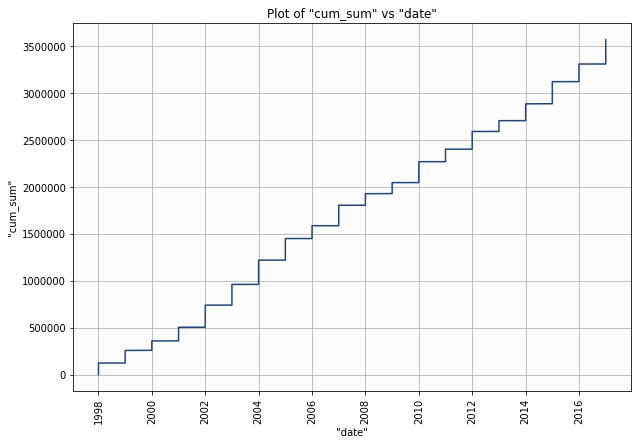

In [10]:
amazon.cumsum("cum_sum", "number", order_by = ["date"])
x = amazon["cum_sum"].plot(ts = "date")

<p style="color:red">The cumulative sum is linear because of the seasonality of forest fires.</p>

<b>Question 3: </b>Mato Grosso seems to be subject to a lot of forest fires. Filter the data and find all the possible information on this State.

In [11]:
amazon.drop(["cum_sum"]).filter("state = 'Mato Grosso'")

vColumn '"cum_sum"' deleted from the vDataframe.
5976 elements were filtered


,year,number,date,month,state
0,1998,0,1998-01-01,April,Mato Grosso
1,1998,0,1998-01-01,April,Mato Grosso
2,1998,0,1998-01-01,February,Mato Grosso
3,1998,0,1998-01-01,February,Mato Grosso
4,1998,0,1998-01-01,January,Mato Grosso
,...,...,...,...,...


<object>  Name: amazon, Number of rows: 478, Number of columns: 5

The new vColumn "cum_sum" was added to the vDataframe.


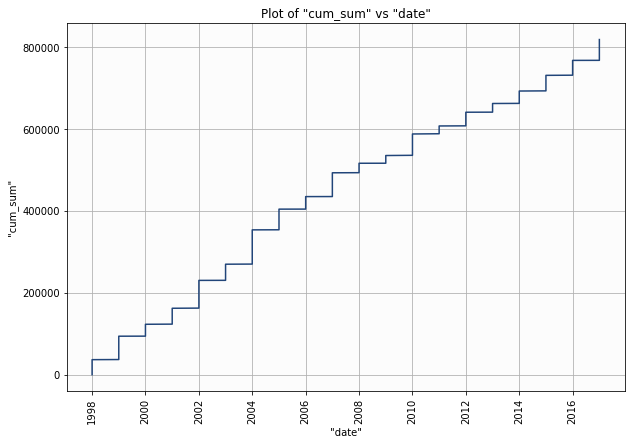

,year,number,date,month,state,cum_sum
0,1998,15406,1998-01-01,August,Mato Grosso,15406
1,1998,10363,1998-01-01,September,Mato Grosso,25769
2,1998,3712,1998-01-01,July,Mato Grosso,29481
3,1998,2707,1998-01-01,October,Mato Grosso,32188
4,1998,2201,1998-01-01,June,Mato Grosso,34389
,...,...,...,...,...,...


<object>  Name: amazon, Number of rows: 478, Number of columns: 6

In [12]:
amazon.cumsum("cum_sum", "number", order_by = ["date"])
amazon["cum_sum"].plot(ts = "date")

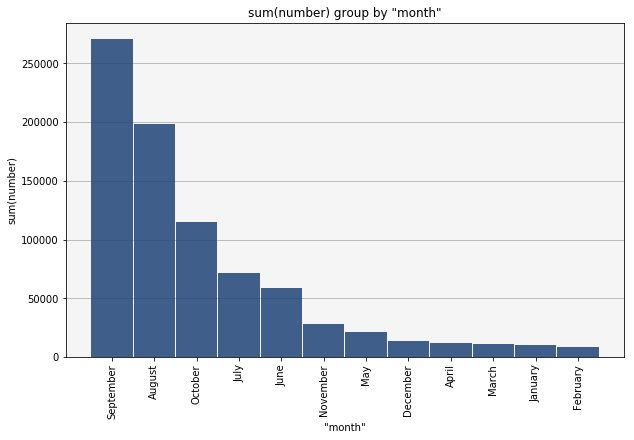

In [13]:
x = amazon["month"].hist(method = "sum", of = "number", max_cardinality = 12, h = 1)

<p style="color:red">Mato Grosso is subject to forest fires mainly between August and October. It is at the beginning of the dried season which makes totally sense. During the raining season the number of forest fires is very low.</p>

<b>Question 4: </b>Plot the cumulative sum of the number of forest fires group by state. 

The new vColumn "cum_sum" was added to the vDataframe.


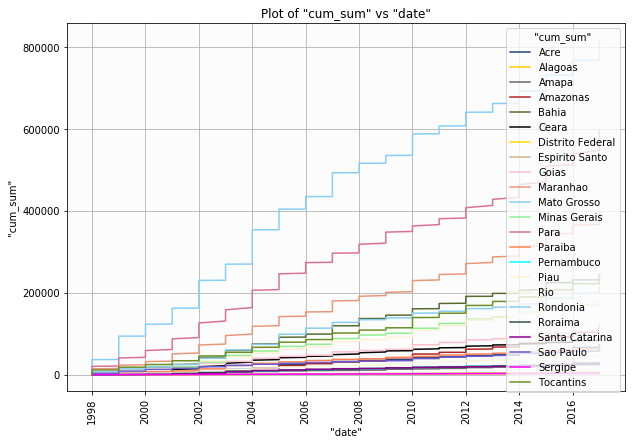

In [14]:
from vertica_ml_python import vDataframe
amazon = vDataframe("amazon", cur).cumsum("cum_sum", "number", by = ["state"], order_by = ["date"])["cum_sum"].plot(ts = "date", by = "state")

The new vColumn "cum_max" was added to the vDataframe.


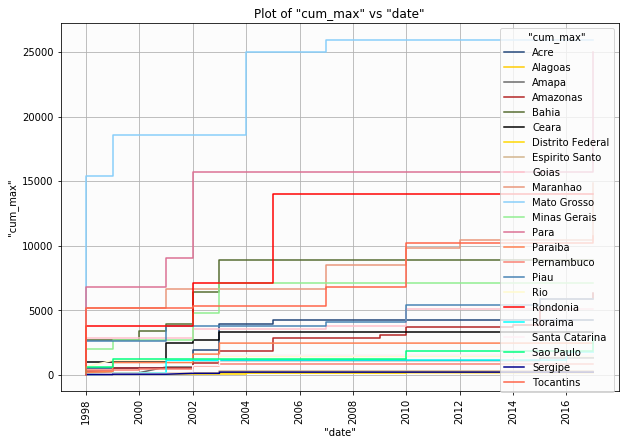

In [15]:
from vertica_ml_python import vDataframe
amazon = vDataframe("amazon", cur).cummax("cum_max", "number", by = ["state"], order_by = ["date"])["cum_max"].plot(ts = "date", by = "state")

<p style="color:red">We can notice that 2004 and 2007 are very important years. The number of forest fires increased considerably. Is it because of some unexpected weather ? We need to invistigate more to get the answer.</p>